In [1]:
# Install the pycoco library as it is not part of the Kaggle environment
!pip install 'git+https://github.com/cocodataset/cocoapi.git#subdirectory=PythonAPI'

  Cloning https://github.com/cocodataset/cocoapi.git to /tmp/pip-req-build-u_1sleoq
  Running command git clone -q https://github.com/cocodataset/cocoapi.git /tmp/pip-req-build-u_1sleoq
  Created wheel for pycocotools: filename=pycocotools-2.0-cp37-cp37m-linux_x86_64.whl size=272558 sha256=d14b68bb667685ec254451871dd3f19aa078a5bcb39f7f33061b8273b4f5a27c
  Stored in directory: /tmp/pip-ephem-wheel-cache-1gmul05v/wheels/e2/6b/1d/344ac773c7495ea0b85eb228bc66daec7400a143a92d36b7b1
Successfully built pycocotools


In [2]:
# Import the necessary libraries
import numpy as np
import random
import cv2
import skimage.io as io
from pycocotools.coco import COCO
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
%matplotlib inline

In [3]:
# Define the image dataset and annotations paths
val_images_path = '../input/food-recognition-challenge/val-v0.4/val/images'
val_anns_path = '../input/food-recognition-challenge/val-v0.4/val/annotations.json'

# Reference Implementation for Generator and Augmentor

https://towardsdatascience.com/master-the-coco-dataset-for-semantic-image-segmentation-part-2-of-2-c0d1f593096a

In [4]:
def filterDataset(ann_path, classes=None):    
    # initialize COCO api for instance annotations
    coco = COCO(ann_path)
    
    images = []
    if classes!=None:
        # iterate for each individual class in the list
        for className in classes:
            # get all images containing given categories
            catIds = coco.getCatIds(catNms=className)
            imgIds = coco.getImgIds(catIds=catIds)
            images += coco.loadImgs(imgIds)
    
    else:
        imgIds = coco.getImgIds()
        images = coco.loadImgs(imgIds)
    
    # Now, filter out the repeated images
    unique_images = []
    for i in range(len(images)):
        if images[i] not in unique_images:
            unique_images.append(images[i])
            
    random.shuffle(unique_images)
    dataset_size = len(unique_images)
    print('\nNumber of images: {}'.format(dataset_size))
    
    return unique_images, coco

In [5]:
def getClassName(classID, cats):
    for i in range(len(cats)):
        if cats[i]['id']==classID:
            return cats[i]['name']
    return None

def getImage(imageObj, img_folder, input_image_size):
    # Read and normalize an image
    train_img = io.imread(img_folder + '/' + imageObj['file_name'])/255.0
    # Resize
    train_img = cv2.resize(train_img, input_image_size)
    if (len(train_img.shape)==3 and train_img.shape[2]==3): # If it is a RGB 3 channel image
        return train_img
    else: # To handle a black and white image, increase dimensions to 3
        stacked_img = np.stack((train_img,)*3, axis=-1)
        return stacked_img
    
def getMask(imageObj, classes, coco, catIds, input_image_size):
    annIds = coco.getAnnIds(imageObj['id'], catIds=catIds, iscrowd=None)
    anns = coco.loadAnns(annIds)
    cats = coco.loadCats(catIds)
    train_mask = np.zeros(input_image_size)
    class_set = set()
    for a in range(len(anns)):
        className = getClassName(anns[a]['category_id'], cats)
        class_set.add(className)
        pixel_value = classes.index(className)+1
        new_mask = cv2.resize(coco.annToMask(anns[a])*pixel_value, input_image_size)
        train_mask = np.maximum(new_mask, train_mask)

    # Add extra dimension for parity with train_img size [X * X * 3]
    train_mask = train_mask.reshape(input_image_size[0], input_image_size[1], 1)
    return train_mask, class_set 

In [6]:
def dataGeneratorCoco(images, classes, coco, img_path, input_image_size=(224, 224), batch_size=4):
    
    dataset_size = len(images)
    catIds = coco.getCatIds(catNms=classes)
    
    c = 0
    cats_lst = []
    while(True):
        img = np.zeros((batch_size, input_image_size[0], input_image_size[1], 3)).astype('float')
        mask = np.zeros((batch_size, input_image_size[0], input_image_size[1], 1)).astype('float')

        for i in range(c, c+batch_size): #initially from 0 to batch_size, when c = 0
            imageObj = images[i]
            
            ### Retrieve Image ###
            train_img = getImage(imageObj, img_path, input_image_size)
            
            ### Create Mask ###
            train_mask, train_cats = getMask(imageObj, classes, coco, catIds, input_image_size)                
            
            # Add to respective batch sized arrays
            img[i-c] = train_img
            mask[i-c] = train_mask
            cats_lst.append(train_cats)
            
        c+=batch_size
        if(c + batch_size >= dataset_size):
            c=0
            random.shuffle(images)
        yield img, mask, cats_lst

In [7]:
def visualizeGenerator(gen):
    img, mask, cats_lst = next(gen)
    
    fig = plt.figure(figsize=(20, 10))
    outerGrid = gridspec.GridSpec(1, 2, wspace=0.1, hspace=0.1)
    
    for i in range(2):
        innerGrid = gridspec.GridSpecFromSubplotSpec(2, 2,
                        subplot_spec=outerGrid[i], wspace=0.05, hspace=0.05)

        for j in range(4):
            ax = plt.Subplot(fig, innerGrid[j])
            if(i==1):
                ax.imshow(img[j])
            else:
                ax.imshow(mask[j][:,:,0])
                
            ax.axis('off')
            for n, e in enumerate(cats_lst[j]):
                if n == 0:
                    title = e
                else:
                    title += ', ' + e
            ax.title.set_text(title)
            fig.add_subplot(ax)        
    plt.show()

loading annotations into memory...
Done (t=0.21s)
creating index...
index created!

Number of images: 54


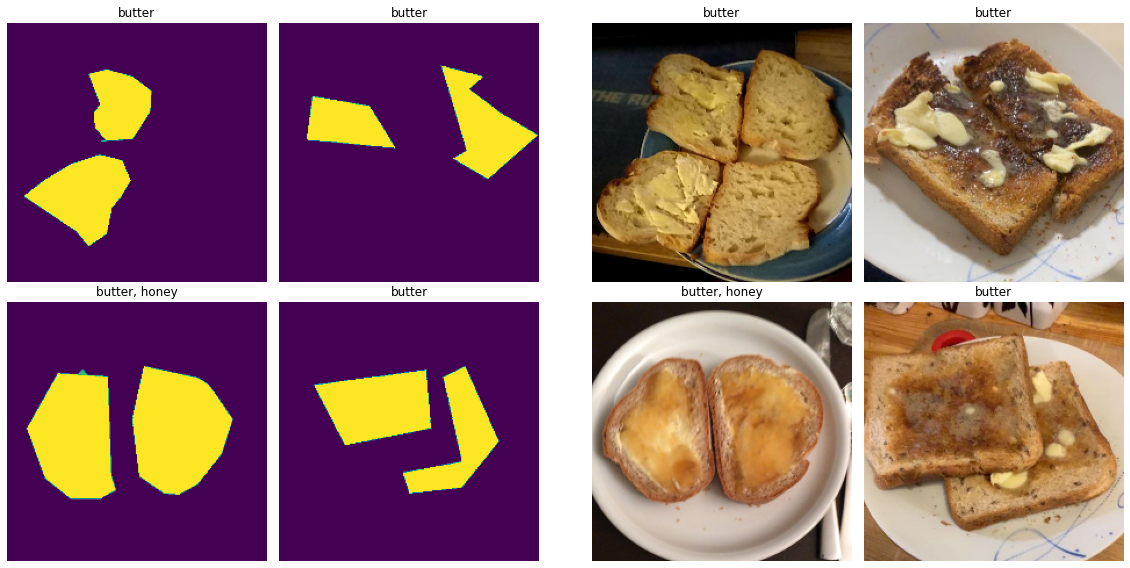

In [8]:
classes = ['bread', 'butter', 'honey']
images, coco = filterDataset(val_anns_path, classes)

batch_size = 4
input_image_size = (224, 224)

val_gen = dataGeneratorCoco(images, classes, coco, val_images_path, input_image_size, batch_size)
visualizeGenerator(val_gen)